In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [221]:
import math

In [2]:
folder = '/media/misha/Data/Game Captures GTA/'

In [173]:
cap = cv2.VideoCapture(folder + '0-country-test.mov')

In [4]:
fgbg = cv2.createBackgroundSubtractorMOG2()
kernel = np.ones((3,3),np.uint8)

### Pipeline
1. Preproces:
    - Convert to Gray
    - Downscale
    - Blur
2. BGS using GMM
3. Find moving objects and track
4. Extract movement features
5. Classify them

Question: how to initialize mean-shift tracking

see: Vehicle tracking by non-drifting mean-shift using projective Kalman filter https://pdfs.semanticscholar.org/c4b0/18193f813eaa8981ee4e85657669e5865fab.pdf

### BGS GMM + Morph_open

In [182]:
r,h,c,w = 100,90,200,125  # simply hardcoded the values
track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 3 )

In [47]:
def preprocessFrame(frame):
#     frame = cv2.resize(frame, (640, 360), interpolation=cv2.INTER_AREA)
    frame_bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_bw = cv2.GaussianBlur(frame_bw, (21, 21), 0)
    return frame_bw

In [246]:
# ret, frame = cap.read()
# fgmask = fgbg.apply(frame)
cap = cv2.VideoCapture(folder + '0-country-test.mov')
fr_number = 0
super_old_cnts = []
old_cnts = []
while(1):
    ret, frame = cap.read()
    frame = cv2.resize(frame, (640, 360), interpolation=cv2.INTER_AREA)
    frame_bw = preprocessFrame(frame)
    fgmask = fgbg.apply(frame_bw)
    flt_fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    flt_fgmask = cv2.threshold(flt_fgmask, 25, 255, cv2.THRESH_BINARY)[1]
    flt_fgmask = cv2.dilate(flt_fgmask, None, iterations=2)
    

#     track some window...
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
    
    ret, track_window = cv2.meanShift(dst, track_window, term_crit)
    x,y,w,h = track_window
    img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
    
#     ret, track_window2 = cv2.meanShift(dst, (x2, y2, w2, h2), term_crit)
#     x2,y2,w2,h2 = track_window2
#     cv2.rectangle(img2, (x2, y2), (x2 + w2, y2 + h2), (255, 255, 0), 2)
    
    cnts = cv2.findContours(flt_fgmask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    
    # Now we have new good contours...
    
    new_cnts = []
    old_cnts = []
    
    for i in range(len(old_cnts)):
        ret, track_window = cv2.meanShift(dst, old_cnts[i], term_crit)
        print(old_cnts[i], track_window, 
              math.sqrt((old_cnts[i][0] - track_window[0])**2 + (old_cnts[i][1] - track_window[1])**2))
    
    for i in range(len(cnts)):
        old_cnts.append(cv2.boundingRect(cnts[i]))
        x,y,w,h = old_cnts[i]
        cv2.rectangle(img2, (x,y), (x+w,y+h), (0, 255, i), 2)
    
    
    for c in cnts:
        if cv2.contourArea(c) < 50:
            continue

            # compute the bounding box for the contour, draw it on the frame,
        (x, y, w, h) = cv2.boundingRect(c)
        
        ret, track_window = cv2.meanShift(dst,  (x, y, w, h), term_crit)
        
#         cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        
        
#     if fr_number % 100 == 0:
#         track_window = (x, y, w, h)
        
    
    cv2.imshow('mask',flt_fgmask)
    cv2.imshow('frame',img2)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    
    fr_number += 1
cap.release()
cv2.destroyAllWindows()

In [240]:
cnts[0][0]

array([[343, 215]], dtype=int32)

In [244]:
for i in range(len(old_cnts)):
        ret, track_window = cv2.meanShift(dst, old_cnts[i], term_crit)
        print(old_cnts[i], track_window, 
              math.sqrt((old_cnts[i][0] - track_window[0])**2 + (old_cnts[i][1] - track_window[1])**2))

(0, 331, 18, 29) (1, 327, 18, 29) 4.123105625617661
(168, 323, 90, 37) (173, 323, 90, 37) 5.0


In [ ]:
math.sqrt

In [233]:
cnts[0]

array([[[347, 156]],

       [[346, 157]],

       [[345, 157]],

       [[343, 159]],

       [[343, 160]],

       [[342, 161]],

       [[342, 164]],

       [[339, 167]],

       [[338, 167]],

       [[337, 168]],

       [[336, 168]],

       [[335, 169]],

       [[334, 169]],

       [[334, 176]],

       [[335, 177]],

       [[334, 178]],

       [[330, 178]],

       [[329, 177]],

       [[326, 177]],

       [[325, 176]],

       [[325, 175]],

       [[324, 174]],

       [[318, 174]],

       [[317, 175]],

       [[313, 175]],

       [[312, 176]],

       [[311, 176]],

       [[310, 177]],

       [[308, 177]],

       [[306, 179]],

       [[305, 179]],

       [[304, 180]],

       [[302, 180]],

       [[301, 181]],

       [[300, 181]],

       [[299, 182]],

       [[298, 182]],

       [[296, 184]],

       [[296, 190]],

       [[297, 191]],

       [[311, 191]],

       [[312, 190]],

       [[314, 190]],

       [[315, 189]],

       [[318, 189]],

       [[3

In [210]:
x

[397, 456, 410, 463]

In [216]:
ret, track_window = cv2.meanShift(dst, cv2.boundingRect(cnts[0]), term_crit)

In [218]:
ret, track_window = cv2.meanShift(dst, cv2.boundingRect(cnts[0]), term_crit)

In [219]:
track_window

(386, 136, 16, 10)

In [214]:
x[:5],y[:5]

([397, 396, 396, 397, 397], [136, 137, 143, 144, 145])

In [220]:
cv2.boundingRect(cnts[0])

(396, 136, 16, 10)

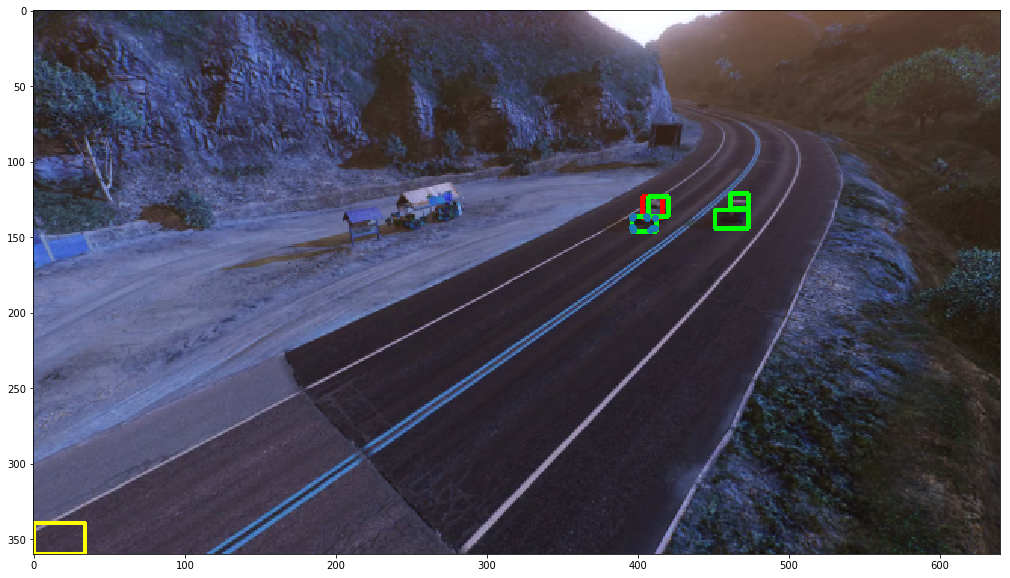

In [213]:
x = []
y = []
for i in range(len(cnts[0])):
    x.append(cnts[0][i][0][0])
    y.append(cnts[0][i][0][1])
#     print(cnts[i][0][0][0])
plt.scatter(x,y)
# plt.imshow(fgmask)
plt.imshow(frame)
plt.show()

In [ ]:
x = []
y = []
print(len(cnts))
for c in cntrs:
#     print(center[0][0])
    x.append(center[0][0][0])
    y.append(center[0][0][1])
#     plt.plot(center[0][0])
plt.scatter(x,y)
# plt.imshow(fgmask)
plt.imshow(frame)
plt.show()

In [16]:
print(type(fgmask))

<class 'NoneType'>


In [121]:
cap = cv2.VideoCapture(folder + '1-highway-test.mov')

In [157]:
for i in range(100):
    ret, frame = cap.read()
    frame = cv2.resize(frame, (640, 360), interpolation=cv2.INTER_AREA)
    fgmask = fgbg.apply(preprocessFrame(frame))

    flt_fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    flt_fgmask = cv2.threshold(flt_fgmask, 25, 255, cv2.THRESH_BINARY)[1]
    flt_fgmask = cv2.dilate(flt_fgmask, None, iterations=2)

In [124]:
print(fgmask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [107]:
cntrs = detect_vehicles(flt_fgmask)

4


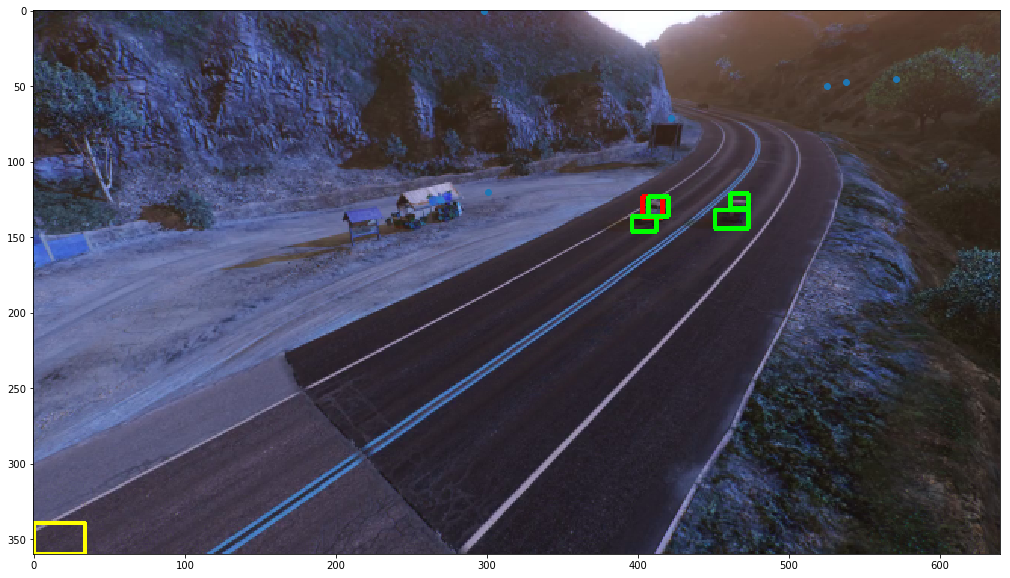

In [200]:
x = []
y = []
print(len(cnts))
for center in cntrs:
#     print(center[0][0])
    x.append(center[0][0][0])
    y.append(center[0][0][1])
#     plt.plot(center[0][0])
plt.scatter(x,y)
# plt.imshow(fgmask)
plt.imshow(frame)
plt.show()

### What are contours
cv2.findContours(), cv2.drawContours()

In [12]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)


In [78]:
def detect_vehicles(fg_mask, min_contour_width=35, min_contour_height=35):

    matches = []

    # finding external contours
    im, contours, hierarchy = cv2.findContours(
        fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

    # filtering by with, height
    for (i, contour) in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        contour_valid = (w >= min_contour_width) and (
            h >= min_contour_height)

        if not contour_valid:
            continue
        
        # getting center of the bounding box
        centroid = get_centroid(x, y, w, h)

        matches.append(((x, y, w, h), centroid))

#     return matches
    return contours

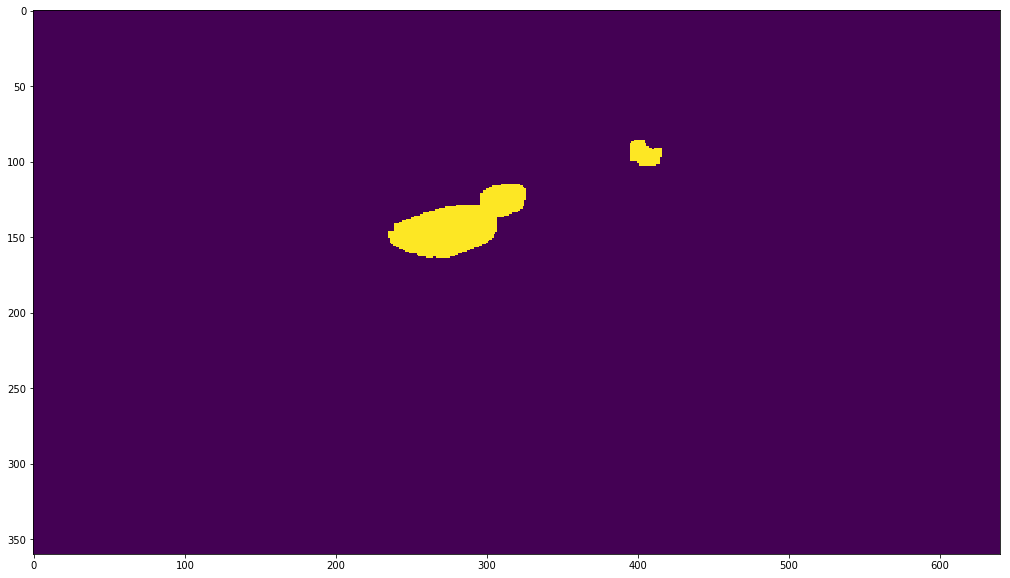

In [94]:
plt.imshow(cv2.dilate(thresh, None, iterations=2))
plt.show()

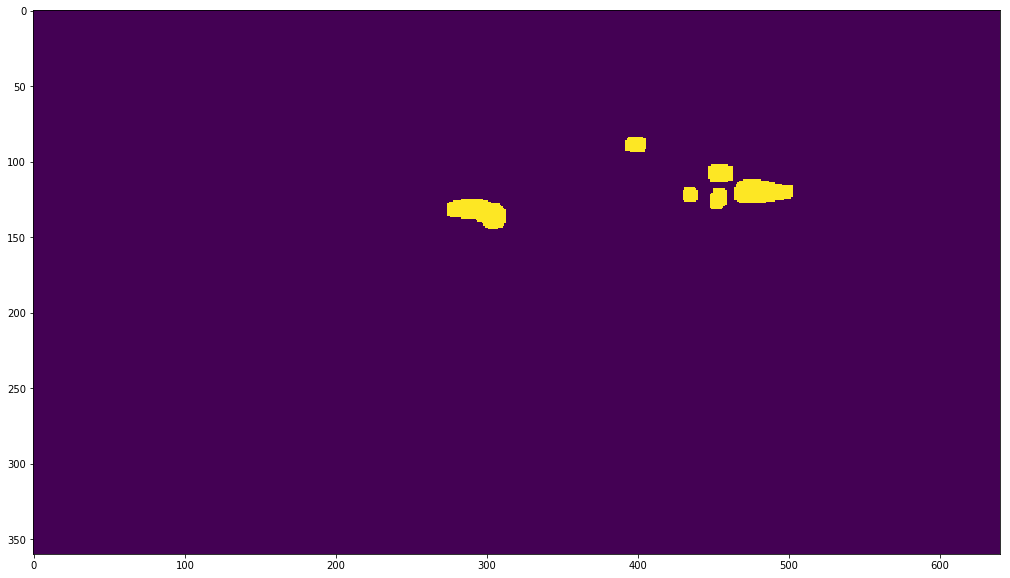

In [158]:
plt.imshow(flt_fgmask)
plt.show()

In [90]:
thresh = cv2.threshold(fgmask, 25, 255, cv2.THRESH_BINARY)[1]

In [161]:
cnts = cv2.findContours(flt_fgmask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

In [162]:
for c in cnts:
    if cv2.contourArea(c) < 50:
        continue
 
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    text = "Occupied"
    print(cv2.contourArea(c))

489.5
118.5
76.5
466.0
157.0
109.5


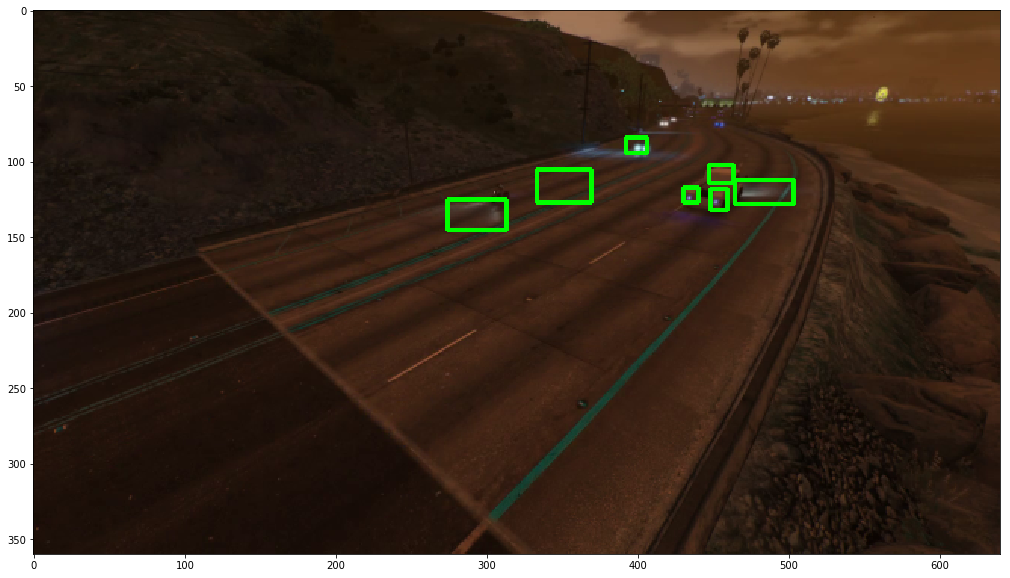

In [163]:
plt.imshow(frame)
plt.show()

In [154]:
len(cnts)

1

In [68]:
ret, frame = cap.read()
fgmask = fgbg.apply(frame)
car_boxes = detect_vehicles(fgmask)
print(car_boxes)

[array([[[408, 383]]], dtype=int32), array([[[399, 383]]], dtype=int32), array([[[413, 382]],

       [[415, 382]]], dtype=int32), array([[[405, 382]]], dtype=int32), array([[[415, 380]]], dtype=int32), array([[[396, 380]]], dtype=int32), array([[[393, 380]]], dtype=int32), array([[[386, 381]]], dtype=int32), array([[[391, 379]]], dtype=int32), array([[[410, 378]]], dtype=int32), array([[[398, 379]],

       [[400, 378]]], dtype=int32), array([[[387, 378]]], dtype=int32), array([[[389, 376]]], dtype=int32), array([[[403, 375]],

       [[402, 377]],

       [[404, 379]],

       [[406, 380]],

       [[408, 379]],

       [[406, 378]],

       [[407, 376]]], dtype=int32), array([[[421, 374]]], dtype=int32), array([[[412, 375]],

       [[412, 378]],

       [[415, 378]],

       [[413, 376]],

       [[416, 376]],

       [[419, 374]],

       [[417, 374]]], dtype=int32), array([[[397, 373]]], dtype=int32), array([[[433, 372]]], dtype=int32), array([[[399, 372]]], dtype=int32), array([

In [78]:
len(car_boxes)

138

In [59]:
bx = car_boxes[0]

In [61]:
bx[0]

(388, 291, 157, 63)

In [79]:
plt.imshow(fgmask,cmap='gray')
for box in car_boxes:
    px = plt.plot(box[1])
    plt.setp(px, linewidth=10, color='r')
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [87]:
for i, elem in enumerate(car_boxes):
    if elem.shape[0] > 35:
        print('lolololololololololololo', i)
        print(elem)

lolololololololololololo 93
[[[473 301]]

 [[464 302]]

 [[458 303]]

 [[457 304]]

 [[453 303]]

 [[455 305]]

 [[451 307]]

 [[446 307]]

 [[445 308]]

 [[441 307]]

 [[444 305]]

 [[442 305]]

 [[440 307]]

 [[438 310]]

 [[434 309]]

 [[434 311]]

 [[431 311]]

 [[429 309]]

 [[427 307]]

 [[426 309]]

 [[422 308]]

 [[425 308]]

 [[426 312]]

 [[425 313]]

 [[423 315]]

 [[420 315]]

 [[420 309]]

 [[418 309]]

 [[412 310]]

 [[410 312]]

 [[406 311]]

 [[405 313]]

 [[401 313]]

 [[400 315]]

 [[397 315]]

 [[396 313]]

 [[393 313]]

 [[389 314]]

 [[386 315]]

 [[383 316]]

 [[381 318]]

 [[379 318]]

 [[378 320]]

 [[376 319]]

 [[374 320]]

 [[371 320]]

 [[364 320]]

 [[363 322]]

 [[359 321]]

 [[357 323]]

 [[355 322]]

 [[352 325]]

 [[354 326]]

 [[354 328]]

 [[351 329]]

 [[348 330]]

 [[348 328]]

 [[348 326]]

 [[348 328]]

 [[346 331]]

 [[349 331]]

 [[353 331]]

 [[354 333]]

 [[356 330]]

 [[360 332]]

 [[358 333]]

 [[359 336]]

 [[361 336]]

 [[363 335]]

 [[365

In [88]:
print(car_boxes[110])

[[[796 182]]

 [[789 184]]

 [[788 186]]

 [[788 188]]

 [[790 189]]

 [[789 191]]

 [[785 193]]

 [[784 195]]

 [[778 194]]

 [[776 196]]

 [[775 194]]

 [[774 196]]

 [[770 197]]

 [[768 197]]

 [[760 197]]

 [[762 196]]

 [[768 197]]

 [[766 199]]

 [[768 200]]

 [[765 202]]

 [[764 200]]

 [[762 200]]

 [[763 202]]

 [[765 202]]

 [[767 201]]

 [[770 201]]

 [[776 200]]

 [[780 203]]

 [[785 203]]

 [[788 205]]

 [[793 205]]

 [[794 207]]

 [[796 206]]

 [[799 205]]

 [[803 207]]

 [[806 206]]

 [[809 204]]

 [[812 204]]

 [[813 202]]

 [[817 202]]

 [[816 200]]

 [[813 197]]

 [[811 197]]

 [[810 195]]

 [[804 195]]

 [[808 194]]

 [[811 193]]

 [[814 192]]

 [[815 190]]

 [[815 186]]

 [[814 184]]

 [[812 185]]

 [[811 183]]

 [[809 182]]

 [[805 181]]]


In [89]:
plt.plot(car_boxes[110])
plt.show()

ValueError: x and y can be no greater than 2-D, but have shapes (55,) and (55, 1, 2)